In [163]:
import sqlite3
import numpy as np
import pandas as pd
from datetime import datetime
from yahoo_finance import Share
import get_historical_price as hp

In [210]:
import urllib2
from BeautifulSoup import BeautifulSoup as bs

def get_historical_price(name, number_of_days):
    data = []
    url = "https://finance.yahoo.com/quote/" + name + "/history/"
    rows = bs(urllib2.urlopen(url).read()).findAll('table')[1].tbody.findAll('tr')

    for each_row in rows:
        d = {}
        divs = each_row.findAll('td')
        date_div = divs[0].span.text
        # I'm only interested in 'Open' for other values, play with divs[1 through 5]
        # print divs[1].span.text
        if divs[1].span.text == 'Dividend':
            continue
            # Ignore this row in the table
        close_text = divs[4].span.text
        d['Date'] = date_div
        d['Close'] = float(close_text.replace(',',''))
        data.append(d)
    return data[:number_of_days]

In [100]:
sqlite_file = '/Users/wuminkai/Project/YahooFinance/data/stock.sqlite'
con = sqlite3.connect(sqlite_file)
cur = con.cursor()
sql_stocks = 'select distinct symbol from Trade'
cur.execute(sql_stocks)
stocks = cur.fetchall()
stocks


sql_share = 'select trader, symbol,sum(share) as share from Trade group by trader,symbol,share having share > 0;'

df_share = pd.read_sql(sql_share, con)
cur.close()


In [102]:
df_share.ix[df_share.shape[0]-1] = ['S&P500', '^GSPC', 1]
df_share

,Trader,Symbol,share
0,simulator1,ACRS,1
1,simulator1,ADXS,1
2,simulator1,ARDX,1
3,simulator1,CERS,1
4,simulator1,LKQ,1
5,simulator1,LMRK,1
6,simulator1,NH,1
7,simulator1,SKIS,1
8,simulator1,SNDX,1
9,simulator1,USCR,1


In [214]:
df_price = pd.DataFrame()
stocks.append(('^GSPC',))
days = (datetime.today()-datetime(2017,1,1)).days
for stock in stocks:
    print stock[0]
#     print get_historical_price(stock[0],5)
    hp = filter(lambda x: datetime.weekday(datetime.strptime(x['Date'],'%b %d, %Y'))==4,get_historical_price(stock[0],days))
    df_temp = pd.DataFrame.from_dict(hp)
    df_temp['Symbol'] = stock[0]
    df_price = df_price.append(df_temp)


ACRS
SKIS
ARDX
CERS
LKQ
LMRK
NH
SNDX
USCR
ADXS
BOFI
COHR
ENTL
EVBG
FPRX
JCOM
NXST
TACO
ACHC
AGRX
BLCM
CVGW
DBVT
EFII
GPP
^GSPC
^GSPC
^GSPC
^GSPC
^GSPC
^GSPC
^GSPC


NameError: name 'df' is not defined

In [218]:
df_price['Date'] =  pd.to_datetime(df_price['Date'])

In [219]:
df_value = df_share.merge(df_price, on='Symbol', how='outer')
df_value['Value'] = df_value['share'] * df_value['Close']

df_sum = df_value.groupby(['Date','Trader'])['Value']\
              .sum()\
              .to_frame()\
              .reset_index()\
              .pivot_table(index='Date', columns='Trader')\
              .reset_index()\
              .rename(columns={(u'Date', u''):'Date'})
df_sum.columns
# df_sum.columns

MultiIndex(levels=[[u'Date', u'Value'], [u'', u'S&P500', u'simulator1', u'simulator2', u'simulator3', u'simulator4', u'simulator5', u'simulator6']],
           labels=[[0, 1, 1, 1, 1, 1, 1, 1], [0, 1, 2, 3, 4, 5, 6, 7]],
           names=[None, u'Trader'])

In [220]:
df_sum1 = df_sum[['Date']].join(df_sum['Value'].divide(df_sum['Value'].ix[0]))\
         .rename(columns={(u'Date', u''):'Date'})\
         .sort_values('Date')
df_sum1

,Date,S&P500,simulator1,simulator2,simulator3,simulator4,simulator5,simulator6
0,2017-01-06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,2017-01-13,0.998972,1.020726,1.025519,1.020025,1.015985,1.007927,1.009710
2,2017-01-20,0.997510,0.989798,0.986121,1.001744,0.984060,0.973734,0.976516
3,2017-01-27,1.007778,1.014390,0.988250,1.016167,0.981293,0.953147,0.946023
4,2017-02-03,1.008977,1.000161,0.979876,1.020258,0.977990,0.932442,0.914085
5,2017-02-10,1.017181,1.003866,0.994506,1.075295,0.990920,0.931614,0.910375
6,2017-02-17,1.032578,1.017236,1.037258,1.082555,1.020092,0.984501,0.972643
7,2017-02-24,1.039684,1.013101,1.028741,1.070135,1.003626,1.023426,1.003546
8,2017-03-03,1.046614,1.072272,1.068338,1.066843,1.010396,1.047681,1.036766
9,2017-03-10,1.041994,1.046392,1.034610,1.064226,0.996175,1.005561,1.000764


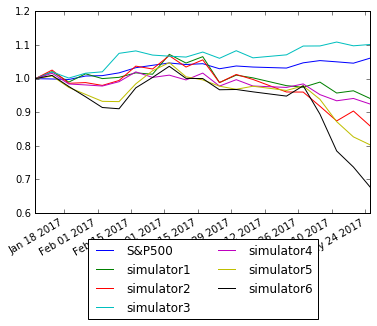

In [222]:
%matplotlib inline
df_sum1.plot(x='Date',kind='line').legend(loc=9,bbox_to_anchor=(0.5, -0.1), ncol=2)

In [3]:
x_dt = pd.date_range('2017-01-01',datetime.datetime.today(), freq='W-Sun')
x_dt

DatetimeIndex(['2017-01-01', '2017-01-08', '2017-01-15', '2017-01-22',
               '2017-01-29', '2017-02-05', '2017-02-12', '2017-02-19',
               '2017-02-26', '2017-03-05', '2017-03-12', '2017-03-19',
               '2017-03-26', '2017-04-02', '2017-04-09', '2017-04-16',
               '2017-04-23', '2017-04-30', '2017-05-07', '2017-05-14',
               '2017-05-21', '2017-05-28'],
              dtype='datetime64[ns]', freq='W-SUN')